Problem 1 : Implementation
=====

In [74]:
import torch
from torch import nn

def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))


torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))



# # Option 1: directly use PyTorch's autograd feature
# for A in A_list:
#     A.requires_grad = True
# for b in b_list:
#     b.requires_grad = True
    
# y = X_data
# for ell in range(L):
#     S = sigma if ell<L-1 else lambda x: x
#     y = S(A_list[ell]@y+b_list[ell])
    
# # backward pass in pytorch
# loss=torch.square(y-Y_data)/2
# loss.backward()

# print(A_list[0].grad)


# Option 2: construct a NN model and use backprop
class MLP(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(4,4) for _ in range(L-1)])
        self.linear.append(nn.Linear(4,1))
        for ell in range(L):
            self.linear[ell].weight.data = A_list[ell]
            self.linear[ell].bias.data = b_list[ell].squeeze()
        
    def forward(self, x) :
        x = x.squeeze()
        for ell in range(L-1):
            x = sigma(self.linear[ell](x))
        x = self.linear[-1](x)
        return x

model = MLP()
            
loss = torch.square(model(X_data)-Y_data)/2
loss.backward()

print(model.linear[0].weight.grad)
print(model.linear[0].bias.grad)
print()

# Option 3: implement backprop yourself
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)


dA_list = []
db_list = []
dy = y-Y_data  # dloss/dy_L
for ell in reversed(range(L)):
    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell] # A = A_l, b = b_l, y_l

    db = torch.mm(dy,torch.diag(S(A@y + b).flatten()))   # dloss/db_ell
    dA = torch.mm(y, db).T   # dloss/dA_ell
    dy = torch.mm(db, A)     # dloss/dy_{ell-1}
    

    dA_list.insert(0, dA)
    db_list.insert(0, db)

print(dA_list[0])
print(db_list[0])


tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05])

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([[4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05]])


Problem 5 : Implementation
======

In [1]:
def get_output_size(H_in,W_in, k, p, s):
    H_out = (H_in - k + 2*p)//s + 1
    W_out = (W_in - k + 2*p)//s + 1
    return H_out,W_out

def trainable_param_num(C_in, C_out,k) :
    return k**2*C_in*C_out + C_out

def addition_num(C_in,H_in,W_in,C_out,k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return (C_in*k**2)*C_out*H_out*W_out

def muliply_num(C_in, C_out,H_in,W_in,k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return C_in*k**2*C_out*H_out*W_out

def activation_num(C_out,H_in,W_in, k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return C_out*H_out*W_out

input_image = [256,32,32]

module_1 = [
    [(128,1),0,1,'conv1'], # [(C_out,k), padding, stride]
    [(192,3),1,1,'conv2'],
    [(96,5),2,1,'conv3'],
    [(256,3),1,1,'maxpool']
]

log1 = dict()
log1['trainable_param_num'] = 0
log1['addition_num'] = 0
log1['multiplication_num'] = 0
log1['activation_num'] = 0

for mod in module_1:
    if mod[-1] == 'maxpool':
        continue
    C_in = input_image[0]
    H_in,W_in  = input_image[1],input_image[2]
    C_out,k = mod[0]
    p = mod[1]
    s = mod[2]
    print(mod[-1])
    print(f"trainable_param_num : {trainable_param_num(C_in,C_out, k)}\naddition_num : {addition_num(C_in,H_in,W_in, C_out,k,p,s)}\nmultiplication_num : {muliply_num(C_in,C_out,H_in, W_in, k,p,s)}\nactivation_num : {activation_num(C_out, H_in, W_in, k, p, s)}\n\n")
    log1['trainable_param_num'] += trainable_param_num(C_in,C_out, k)
    log1['addition_num'] += addition_num(C_in,H_in,W_in, C_out,k,p,s)
    log1['multiplication_num'] += muliply_num(C_in,C_out,H_in, W_in, k,p,s)
    log1['activation_num'] += activation_num(C_out, H_in, W_in, k, p, s)

print(f"--TOTAL-- \ntrainable_param_num = {log1['trainable_param_num']}\naddition_num = {log1['addition_num']}\nmultiplication_num = {log1['multiplication_num']}\nactivation_num = {log1['activation_num']}")


conv1
trainable_param_num : 32896
addition_num : 33554432
multiplication_num : 33554432
activation_num : 131072


conv2
trainable_param_num : 442560
addition_num : 452984832
multiplication_num : 452984832
activation_num : 196608


conv3
trainable_param_num : 614496
addition_num : 629145600
multiplication_num : 629145600
activation_num : 98304


--TOTAL-- 
trainable_param_num = 1089952
addition_num = 1115684864
multiplication_num = 1115684864
activation_num = 425984


In [2]:
def get_output_size(H_in,W_in, k, p, s):
    H_out = (H_in - k + 2*p)//s + 1
    W_out = (W_in - k + 2*p)//s + 1
    return H_out,W_out

def trainable_param_num(C_in, C_out,k) :
    return k**2*C_in*C_out + C_out

def addition_num(C_in,H_in,W_in,C_out,k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return (C_in*k**2)*C_out*H_out*W_out

def muliply_num(C_in, C_out,H_in,W_in,k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return C_in*k**2*C_out*H_out*W_out

def activation_num(C_out,H_in,W_in, k, p, s):
    H_out,W_out = get_output_size(H_in,W_in,k,p,s)
    return C_out*H_out*W_out

input_image = [256,32,32]

module_2 = [
    [[(128,1),0,1,'conv1']], # [(C_out,k), padding, stride]
    [[(64,1),0,1,'conv2'],[(192,3),1,1,'conv3']],
    [[(64,1),0,1,'conv4'],[(96,5),2,1,'conv5']],
    [[(256,3),1,1,'maxpool'],[(64,1),0,1,'conv6']]
]

log2 = dict()
log2['trainable_param_num'] = 0
log2['addition_num'] = 0
log2['multiplication_num'] = 0
log2['activation_num'] = 0

for submod in module_2:
    if len(submod)>1:
        isOverlap = True
    for i in range(len(submod)):
        if submod[i][-1] == 'maxpool':
            continue
        if i == 1:
            intermediate_feature = submod[0]
            H,W = get_output_size(input_image[1],input_image[2],intermediate_feature[0][1],intermediate_feature[1],intermediate_feature[2])
            input_feature = [intermediate_feature[0][0],H,W]
        else:
            input_feature = input_image
        
        C_in = input_feature[0]
        H_in = input_feature[1]
        W_in = input_feature[2]
        C_out, k = submod[i][0]
        p = submod[i][1]
        s = submod[i][2]

        print(submod[i][-1])
        print(f"trainable_param_num : {trainable_param_num(C_in,C_out, k)}\naddition_num : {addition_num(C_in,H_in,W_in, C_out,k,p,s)}\nmultiplication_num : {muliply_num(C_in,C_out,H_in, W_in, k,p,s)}\nactivation_num : {activation_num(C_out, H_in, W_in, k, p, s)}\n\n")
        log2['trainable_param_num'] += trainable_param_num(C_in,C_out, k)
        log2['addition_num'] += addition_num(C_in,H_in,W_in, C_out,k,p,s)
        log2['multiplication_num'] += muliply_num(C_in,C_out,H_in, W_in, k,p,s)
        log2['activation_num'] += activation_num(C_out, H_in, W_in, k, p, s)
    

print(f"--TOTAL-- \ntrainable_param_num = {log2['trainable_param_num']}\naddition_num = {log2['addition_num']}\nmultiplication_num = {log2['multiplication_num']}\nactivation_num = {log2['activation_num']}")


conv1
trainable_param_num : 32896
addition_num : 33554432
multiplication_num : 33554432
activation_num : 131072


conv2
trainable_param_num : 16448
addition_num : 16777216
multiplication_num : 16777216
activation_num : 65536


conv3
trainable_param_num : 110784
addition_num : 113246208
multiplication_num : 113246208
activation_num : 196608


conv4
trainable_param_num : 16448
addition_num : 16777216
multiplication_num : 16777216
activation_num : 65536


conv5
trainable_param_num : 153696
addition_num : 157286400
multiplication_num : 157286400
activation_num : 98304


conv6
trainable_param_num : 16448
addition_num : 16777216
multiplication_num : 16777216
activation_num : 65536


--TOTAL-- 
trainable_param_num = 346720
addition_num = 354418688
multiplication_num = 354418688
activation_num = 622592


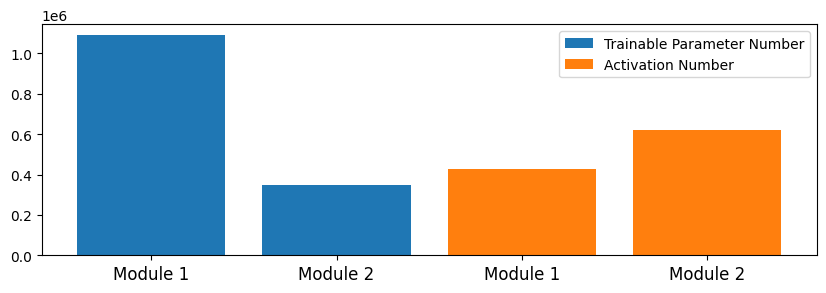

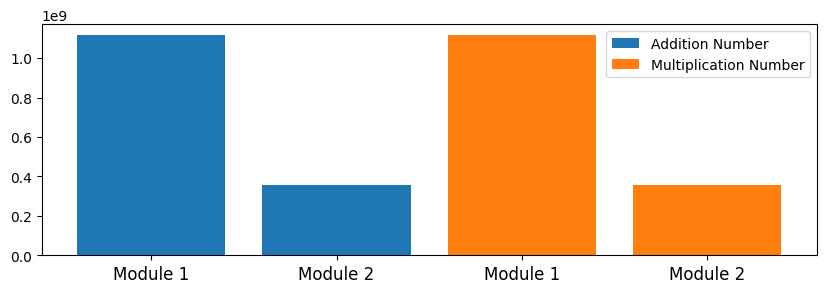

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(1,1,1)
ax.bar([1,2],[log1['trainable_param_num'],log2['trainable_param_num']],label = "Trainable Parameter Number")
ax.bar([3,4],[log1['activation_num'],log2['activation_num']],label = "Activation Number")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Module 1', 'Module 2', 'Module 1','Module 2'], fontsize=12)
ax.legend()

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(1,1,1)
ax.bar([1,2],[log1['addition_num'],log2['addition_num']],label = "Addition Number")
ax.bar([3,4],[log1['multiplication_num'],log2['multiplication_num']],label = "Multiplication Number")
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Module 1', 'Module 2', 'Module 1','Module 2'], fontsize=12)
ax.legend()